# TensorFlow lab 2: MNIST with softmax regression

MNIST is a dataset of grayscale images of handwritten digits, released by the National Institute of Standards and Technology.

I'll give you the code to build a softmax regression model, but feel free to throw something more interesting in there.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import sklearn.decomposition

%matplotlib inline
from IPython.core.pylabtools import figsize

In [2]:
tf.__version__

'1.3.0'

## Load the dataset

TensorFlow comes with some convenience functions for loading the train and test sets.

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

Edit the `"data/"` to wherever you hid the files.

In [4]:
mnist = input_data.read_data_sets("data/")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [5]:
mnist.train

The images in the dataset are 28x28 pixels. When we load them we'll get an Nx784 matrix of unravelled images.

In [6]:
mnist.train.images.shape

(55000, 784)

The labels will be an array of numbers between 0 and 9:

In [7]:
mnist.train.labels.shape

(55000,)

In [8]:
mnist.train.labels[:10]

array([7, 3, 4, 6, 1, 8, 1, 0, 9, 8], dtype=uint8)

When training our model, we'll need to convert these to a "one-hot" encoding. So a label of 0 will be

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

and a label of 1 would be

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

etc

## EDA

The most effective way to accidentally do something stupid in a machine learning problem is to not look at your data. So if that's your goal please skip this section.

### Look at the data

Let's randomly select a few images from the training set and plot them (including the corresponding label). Notice that for each, we'll pull one row out of our data matrix and reshape it to (28,28).

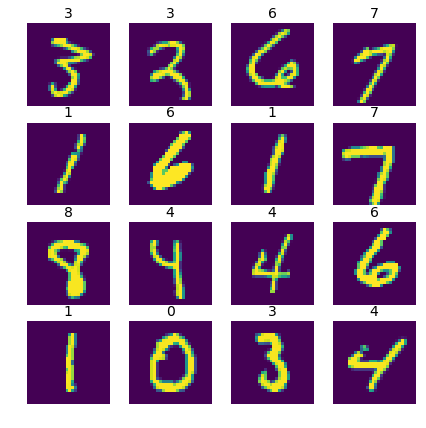

In [9]:
figsize(7,7)
num_train = mnist.train.images.shape[0]

for i in range(16):
    plt.subplot(4,4,i+1)
    # pick a training example
    example = np.random.choice(np.arange(num_train))
    # plot the image
    plt.imshow(mnist.train.images[example,:].reshape((28,28)), interpolation="none")
    plt.axis("off")
    # label with the correct answer
    plt.title(mnist.train.labels[example], fontsize=14);

### Check the class balance

If the number of examples from each class is imbalanced, we could wind up with a classifier that gets great accuracy scores but is functionally useless. This shouldn't be a problem today:

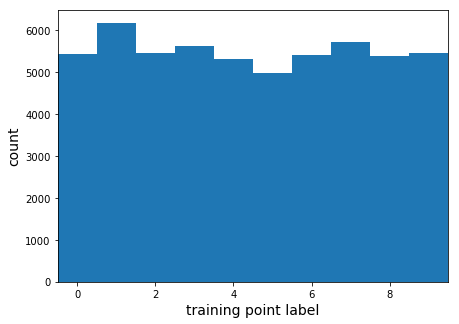

In [10]:
figsize(7,5)
# what's our class balance look like?
_ = plt.hist(mnist.train.labels, bins=np.arange(11)-0.5)
plt.xlim(-0.5,9.5)
plt.xlabel("training point label", fontsize=14)
plt.ylabel("count", fontsize=14);

### Unsupervised learning

In a lot of contexts, a 784 is a lot of columns to have in your dataset. Do we really need all of them?

Since we're building a linear model, Principal Component Analysis (PCA) would be a logical check to run- it will find a linear transformation on the entire dataset such that the first dimension contains the most variance, the second contains the second-most, etc.

We can plot the total fraction of the dataset's variance that's explained as we add principal components one at a time:

In [11]:
pca = sklearn.decomposition.PCA().fit(mnist.train.images)

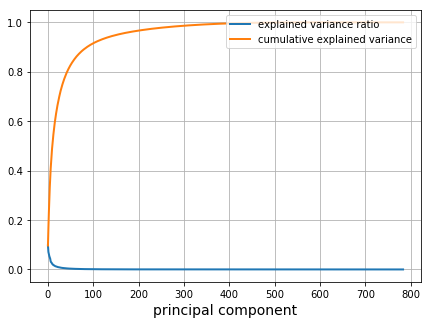

In [12]:
figsize(7,5)
plt.plot(pca.explained_variance_ratio_, lw=2, label="explained variance ratio")
plt.plot(pca.explained_variance_ratio_.cumsum(), lw=2, label="cumulative explained variance")
plt.xlabel("principal component", fontsize=14)
plt.legend(loc="upper right")
plt.grid("on")

So the answer to "do we really need all these dimensions?" is an emphatic **no.** We could throw out 90% of them and still have 90% of the variance in the data. This will be our first warning that a linear model might not be what we need.

Just for fun- let's take a look at the first few principal components. These images represent the feature-space dimensions of highest variance:

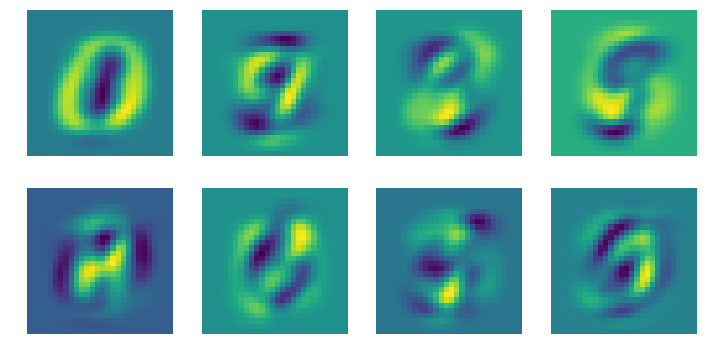

In [13]:
figsize(12,6)
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(pca.components_[i,:].reshape((28,28)), interpolation="none")
    plt.axis("off")

## Build the model

### Get the data in

For this example, we'll manually load the data in one batch at a time. For grown-up machine learning problems TensorFlow has some really powerful tools for loading, shuffling, and augmenting data for the next batch on your CPU while your GPU chugs away on the last batch.

For now, though- we'll make placeholders to input a batch of images and a batch of corresponding labels, and an operation to convert the labels to one-hot encoding.

In [14]:
x = tf.placeholder(tf.float32, [None, 784], name="data_placeholder")
y_ = tf.placeholder(tf.int32, [None,], name="label_placeholder")

y_oh = tf.one_hot(y_, 10, name="labels_one_hot")

Note that the shape of the first tensor is `[None, 784]`. This tells tensorfow to allow for inputs of variable sizes; it just expects a 2D array with 784 columns.

You can only have up to one `None` entry in the tensor shape.

### Softmax regression (Goodfellow section 6.2)

**TL;DR:** *it's just logistic regression for more than one class*

Our model will basically be a stack of linear models, one for each class. We'll have a (10x784) matrix of weights and an array of 10 offsets. The linear part for class $i$ is:

$z_{i} = \sum_{j} W_{i,j}x_{j} + b_{i}$

The softmax output for class $i$ will be the exponent of the linear model results, normalized by the exponent for all the classes:

$softmax(z)_{i} = \frac{\exp(logit_{i})}{\sum_{j}\exp(logit_{j})}$

The normalization ensures that the softmax values for every class will add up to 1, so we can interpret it as a probability distribution over classes (some of you will note that if you interpret the linear models as dimensionless energy this is just the Gibbs distribution).

#### Numerical stability (Goodfellow section 4.1)

**TL;DR:** *use the convenience functions*

TensorFlow comes with a bunch of little utility functions like `tf.nn.softmax_cross_entropy_with_logits` for computing softmax. They're not just there for convenience: even though the above equation is really simple, there's a lot that can go wrong with it when you're calculating it on a computer. 

Those utility functions are doing a bunch of stabilization against overflow underflow. I can assure you that if you just code up softmax manually and try to train a neural network, you will get bizarre and useless results.

We'll use `tf.Variable` objects for the weight matrix and bias, since they need to be trainable. And we can use a matrix multiplication to compute the linear outputs for each class in a single step:

In [15]:
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

y = tf.matmul(x,W) + b

### Loss function: Cross-Entropy (Goodfellow sections 3.13, 5.5)

To train our model, we need a loss function that we can give to an optimizer.

Why not just use accuracy? Because the accuracy function won't give us nice gradients- every time the class boundary crosses a data point, the accuracy will suddenly change by a fixed amount. And a classifier that *just barely* classifies everything right won't be any better or worse than one that puts the decision boundary dead in the middle.

A standard loss function to use for classification problems that will give us a nice gradient is the **cross-entropy**. For every training point, we have a label $y_{i}$ that tells us which category it belongs in. Since our model outputs a probability distribution $p$, then $p_{y_{i}}$ is a measure of how likely the network thinks that the correct label is.

You *could* try to optimize directly on those probabilities- but in cases where the probabilities get bunched up around 0, it'll be hard to differentiate between 0.001 and 0.000001. In practice you'll get better results if you use a logarithm to spread them out. The cross entropy will be:

$c = -\sum_{i}\log(p_{y_{i}})$

In information theory the inverse log probability ($-log(p)$) is called the **self-information.** I've come across anomaly detection papers that use it as a measure of "surprise"- the lower the probability, the more bits of self-information because the result is more surprising. So we're essentially minimizing how surprising the model thinks the training set labels are.

Note that this is one of those times when we're going to use a convenience function for softmax.

In [16]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits=y))

### Optimization: Stochastic Gradient Descent (Goodfellow section 4.3)

I know I've recklessly thrown the phrase "gradient descent" around a lot already. I promise we'll go through it in detail when we get to the next chapter.

Until then: the idea here is to iteratively update the model parameters by (at each iteration) tweaking them in the direction that improves the loss function the most.

So if you went hiking, and found the top of the hill by pointing yourself in the steepest direction, then taking a step, then repeating until you stopped going up, then you would be doing gradient descent.

The learning rate sets the size of our steps. Bigger steps will get us there faster but tend to overshoot the actual optimum; smaller steps won't overshoot but take forever to get there. If you're feeling especially clever: add a learning rate placeholder so you can start with a large value and gradually decrease it during training.

In [17]:
learnrate = 0.1

In [18]:
optimizer = tf.train.GradientDescentOptimizer(learnrate)
train_step = optimizer.minimize(cross_entropy)

### Measuring performance: accuracy (Goodfellow section 11.1)

This is just the fraction of cases that the classifier got right.

* If you haven't used an `argmax` function before, it returns the position in the array that has the largest value.
* The `tf.equal` function will return a Boolean array that's True for all the values that are equivalend (e.g whenever the predicted class is the actual class)
* `tf.cast` turns one data type (in this case, a Boolean) into another (in this case, a float). So `True` becomes 1.0 and `False` becomes 0.

In [19]:
prediction = tf.argmax(y,1)
correct_prediction = tf.equal(prediction, tf.argmax(y_oh,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Train the model

In [20]:
%%time
numsteps = 1000
# create an empty array to hold test accuracy at each step
test_acc = np.zeros(numsteps)

test_batchsize = 10000 # make sure it's an integer multiple of
                        # the number of test examples
num_test_batches = int(len(mnist.test.labels)/test_batchsize)

# create a session to run in
with tf.Session() as sess:
    # initialize variables
    tf.global_variables_initializer().run()
    # for each training step
    for i in range(numsteps):
        # pull the next batch of images and labels
        batch_xs, batch_ys = mnist.train.next_batch(100)
        # feed them to the training operation
        fd = {x:batch_xs, y_:batch_ys}
        sess.run(train_step, feed_dict=fd)
        
        # now that we've updated the model weights, let's
        # compute the test accuracy
        acc = 0
        for j in range(num_test_batches):
            b_x, b_y = mnist.test.next_batch(test_batchsize)
            acc += sess.run(accuracy, feed_dict={x:b_x, y_:b_y})
        test_acc[i] = acc/num_test_batches
        #test_acc[i] = sess.run(accuracy, feed_dict={x:mnist.test.images, y_:mnist.test.labels})
        
    # let's also save the final predictions for each test point
    test_predictions = []
    for j in range(num_test_batches):
        b_x, b_y = mnist.test.next_batch(test_batchsize)
        test_predictions.append(
            sess.run(prediction,
                     feed_dict={x:b_x, y_:b_y}))
    test_predictions = np.concatenate(test_predictions)
    #test_predictions = sess.run(prediction, feed_dict={x:mnist.test.images, y_:mnist.test.labels})

print("Final accuracy: %s"%round(test_acc[-1],3))

Final accuracy: 0.911
CPU times: user 37 s, sys: 1.52 s, total: 38.5 s
Wall time: 34.6 s


## Interpret results

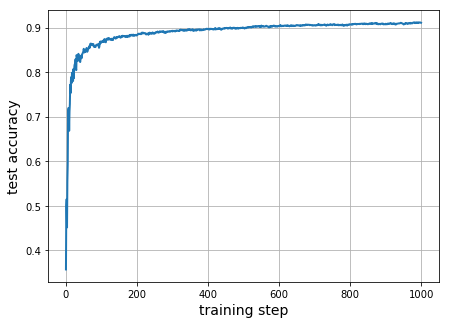

In [21]:
figsize(7,5)
plt.plot(test_acc, lw=2)
plt.xlabel("training step", fontsize=14)
plt.ylabel("test accuracy", fontsize=14)
plt.grid("on");

### Confusion matrix

For each actual class, let's compare counts of how many times it was categorized into the other classes

In [22]:
conf_mat = np.zeros((10,10))

for i in range(len(test_predictions)):
    conf_mat[mnist.test.labels[i], test_predictions[i]] += 1

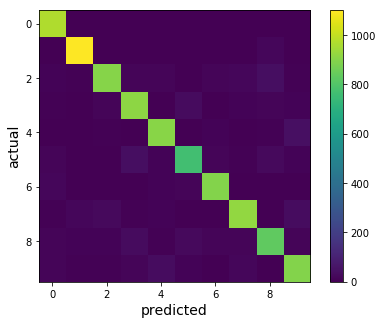

In [23]:
plt.imshow(conf_mat, interpolation="none")
plt.xlabel("predicted", fontsize=14)
plt.ylabel("actual", fontsize=14)
plt.colorbar();

Overall this is a pretty nice confusion matrix- there isn't one particular class that gets consistently misclassified. We can still poke around and see what the examples look like where (for example) 2's are misclassified as 8's.

In [24]:
def compare_misclass(a,b):
    """
    Plot up to 16 examples where a test case from class a was mislabeled as class b
    """
    misclassified = (mnist.test.labels == a)&(test_predictions == b)
    misclass_indices = np.arange(len(misclassified))[misclassified]
    for i in range(16):
        if i < len(misclass_indices):
            plt.subplot(4,4,i+1)
            example = misclass_indices[i]
            plt.imshow(mnist.test.images[example,:].reshape((28,28)), interpolation="none")
            plt.axis("off")

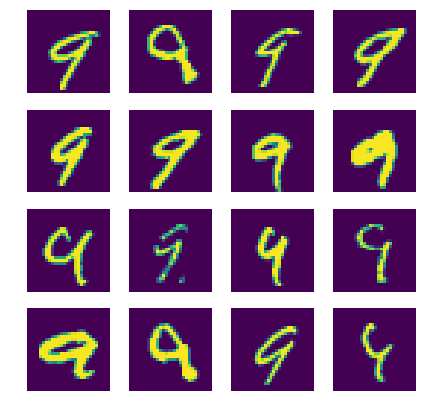

In [25]:
figsize(7,7)
compare_misclass(9,4)

## More models

If you'd like to try attacking the problem with something more exotic than a linear model, here's your chance. Comment out the block of code that looks like:

```
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

y = tf.matmul(x,W) + b
```

And replace is with whatever you want- but it should input the (?,784) tensor $x$ and output the (?,10) tensor $y$. Some suggestions:

* Don't forget to use `tf.reset_default_graph()` if you're starting over with a new model.
* The `tensorflow.contrib.slim` module has a bunch of premade layers with tons of options built-in.
* If you're cranking up the model complexity, try running a lower number of training steps the first time- the compute time goes up *sharply.* Once you know what you're getting into, you may need to increase the number of steps for bigger models.
* If you're running this while logged into a shared virtual machine- you may want to move your computation somewhere else. You can download the notebook as a .py file, strip out the EDA stuff, and run it on a cluster node pretty easily.

In [26]:
tf.reset_default_graph()

In [16]:
from tensorflow.contrib import slim

### Multilayer perception (Goodfellow chapter 6)

Here's a simple, shallow feed-forward neural network with 100 hidden neurons with Rectified Linear Unit activations (Goodfellow section 6.3).

I got a final test accuracy of 0.94.

In [71]:
hidden = slim.relu(x, 100)
y = slim.linear(hidden, 10)

### Convolutional Neural Network (Goodfellow chapter 9)

Here's the convolutional version of the perceptron above. Note that to make use of the structure of the image, we have to reshape the (?,784) input tensor to (?,28,28,1) at the start and then flatten it back at the end (the 1 is the number of channels; a color image would have a 3 here).

I got a final test accuracy of 0.96 here, though it's considerably slower to compute than the MLP.

In [81]:
x_img = tf.reshape(x, [-1, 28, 28,1])
hidden = slim.conv2d(x_img, 100, [3,3])
flattened = slim.flatten(hidden)
y = slim.linear(flattened, 10)

### Deep convolutional network

Uses pooling (Goodfellow section 9.3) and dropout regularization (Goodfellow section 7.12).

I got a final test accuracy of 0.982 in 2000 steps (dropout slows down the training speed). This took about 12 minutes on my GPU.

In [ ]:
x_img = tf.reshape(x, [-1, 28, 28,1])
# first block- output is (?, 14, 14, 64)
net = slim.conv2d(x_img, 32, [3,3])
net = slim.conv2d(net, 64, [3,3])
net = slim.max_pool2d(net, [2,2], stride=[2,2])
# second block- output is (?, 7, 7, 96)
net = slim.conv2d(net, 48, [1,1])
net = slim.conv2d(net, 64, [3,3])
net = slim.conv2d(net, 96, [3,3])
net = slim.max_pool2d(net, [2,2], stride=[2,2])
# third block- output is  (?, 1,1, 128)
net = slim.conv2d(net, 64, [1,1])
net = slim.conv2d(net, 96, [3,3])
net = slim.conv2d(net, 128, [3,3])
net = slim.max_pool2d(net, [7,7])
# flatten, dropout, and linear output for softmax
flattened = slim.flatten(net)
dropout = slim.dropout(flattened, 0.5)
y = slim.linear(dropout, 10)